# Analyse crime patterns based upon available data

## API / Dataset

### City of Los Angeles Open Data

Leveraging data set made available by the City of Los Angeles to gain some insights into well published crime in the City of Los Angeles.

Per the City of Los Angeles open data set description:

<b>Crime Data from 2010 to Present</b>

This dataset reflects incidents of crime in the City of Los Angeles dating back to 2010. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data. Some location fields with missing data are noted as (0°, 0°). Address fields are only provided to the nearest hundred block in order to maintain privacy. This data is as accurate as the data in the database. 

https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq

### Library uszipcode

Use of publicly available library to reverse geocode the latitude and longitude coordinates to a zip code.

### Library gmaps
Use of publicly available library to visualize geographical data through google maps.

In [367]:
%matplotlib inline
import pandas as pd
from sodapy import Socrata
from uszipcode import SearchEngine # note this does an approximation of zipcode based upon a radius
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median
import gmaps
import gmaps.datasets
# import pickle

In [368]:
# pd.options.display.max_columns=20

In [369]:
# client = Socrata("data.lacity.org", None)

# results = client.get("7fvc-faax", limit=2000000)
# # results = client.get("7fvc-faax", limit=200)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

In [370]:
# # drop irrelevant columns
# results_df.drop(columns=[':@computed_region_2dna_qi2s',
#  ':@computed_region_k96s_3jcv',
#  ':@computed_region_kqwf_mjcx',
#  ':@computed_region_qz3q_ghft',
#  ':@computed_region_tatf_ua23',
#  ':@computed_region_ur2y_g4cx',
#  'crm_cd_1',
#  'crm_cd_2',
#  'crm_cd_3',
#  'crm_cd_4',                        
#  'cross_street'], inplace=True)

In [371]:
# results_df.head()

In [372]:
# with open('results_df.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(results_df, f, pickle.HIGHEST_PROTOCOL)

In [373]:
# with open('results_df.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     results_df = pickle.load(f)

In [374]:
# list(results_df)

In [375]:
# rows=len(results_df)
# search = SearchEngine(simple_zipcode=True)
# lon = []
# lat = []
# zipcode = []
# year_single = '2000'
# year = []
# for i in range(rows):
#     # single values for readability
#     lattitude = float(results_df['location_1'][i]['coordinates'][1])
#     longitude = float(results_df['location_1'][i]['coordinates'][0])
#     year_single = results_df['date_occ'][i][:4]
#     # append to arrays
#     lon.append(longitude)
#     lat.append(lattitude)
#     try:
#         zipcode.append(search.by_coordinates(lattitude, longitude, radius=5, returns=1)[0].zipcode)
#     except:
#         zipcode.append('00000')
#         print(f'{i},{lattitude},{longitude}')
#     year.append(year_single)
# results_df['lat'] = lat
# results_df['lon'] = lon
# results_df['zipcode'] = zipcode
# results_df['year'] = year

In [376]:
# len(results_df)

In [377]:
# # remove lines with no corresponding zip code
# results_df = results_df[results_df.zipcode != '00000']
# len(results_df)

In [378]:
# results_df.head()

In [379]:
# results_df['zipcode']=pd.to_numeric(results_df.zipcode)
# results_df['year']=pd.to_numeric(results_df.year)
# results_df['crm_cd']=pd.to_numeric(results_df.crm_cd)

In [380]:
# # in case you want to keep run the data from the cvs file instead of the api
# file_name='Resources\los_angeles_crime_statistics.csv'
# results_df.to_csv(file_name, encoding='utf-8')

In [381]:
# if you have the csv file available and want to pull the data from the csv file, uncomment next line
results_df=pd.read_csv('Resources\los_angeles_crime_statistics.csv')

In [382]:
# Read income and housing data by zipcode csv file
zip_home_income=pd.read_csv('Resources\CA_zip_home_income.csv')
zip_home_income.head()

,Median Home Value,Median Household Income,Zip Code
0,249600.0,35097.0,90001
1,216100.0,31258.0,90002
2,231700.0,29686.0,90003
3,776300.0,37976.0,90004
4,633600.0,31893.0,90005


In [383]:
# Rename Zip Code column to zipcode
zip_home_income=zip_home_income.rename(columns = {"Zip Code":"zipcode"})
zip_home_income.head()

,Median Home Value,Median Household Income,zipcode
0,249600.0,35097.0,90001
1,216100.0,31258.0,90002
2,231700.0,29686.0,90003
3,776300.0,37976.0,90004
4,633600.0,31893.0,90005


In [384]:
# Join crime data, income and housing data on zipcode
results_merged = pd.merge(results_df,zip_home_income,on=["zipcode"], how = "left")

In [385]:
results_merged.head()

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010,945000.0,71589.0
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010,945000.0,71589.0
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010,941100.0,72701.0
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010,633600.0,31893.0
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0


In [386]:
results_df = results_merged

In [387]:
# FD: The analysis can only be as good as the underlying data
# https://www.latimes.com/local/crime/la-me-lapd-audit-20151206-story.html

In [388]:
# FD: Crime classifications, the good, the bad and the ugly
# Modernizing Crime Statistics: Report 1: Defining and Classifying Crime (2016)
# Chapter: 5 Proposed Classification of Crime for Statistical Purposes
# https://www.nap.edu/read/23492/chapter/7#121

In [389]:
# get all crime codes with description and validate it is a one to one code versus description
aggregation = { 
     'crm_cd_desc': 'nunique' 
}
crime_codes = results_df.groupby(['crm_cd','crm_cd_desc']).agg(aggregation)

#crime_codes.to_csv('crime codes.csv', encoding='utf-8')
# manual determination of violent crime as no indicator available to determine violent crime.
# The LA Times article describes violent crime as 'violent crime — which includes homicide, rape, robbery and aggravated assault'.
crime_codes

,,crm_cd_desc
crm_cd,crm_cd_desc,
110,CRIMINAL HOMICIDE,1
113,"MANSLAUGHTER, NEGLIGENT",1
121,"RAPE, FORCIBLE",1
122,"RAPE, ATTEMPTED",1
210,ROBBERY,1
220,ATTEMPTED ROBBERY,1
230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1
231,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,1
235,CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,1


In [390]:
# general crime historical review ###############################################3

In [391]:
# remove 2019
processing_df = results_df.loc[results_df['year'] != 2019]

years = processing_df.year.unique()
years.sort
years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

In [392]:
processing_df.head()

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010,945000.0,71589.0
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010,945000.0,71589.0
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010,941100.0,72701.0
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010,633600.0,31893.0
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0


In [393]:
# group by year / zipcode ; count number of crimes (dr_no)
zip_crime_intermediate = processing_df.sort_values(by=['zipcode'])
aggregation = { 
     'dr_no': 'count' 
}
zip_crime = zip_crime_intermediate.groupby(['zipcode']).agg(aggregation)
zip_crime = zip_crime.sort_values(by=['dr_no'], ascending=False)
zip_crime.reset_index(level=0, inplace=True)
zip_crime.head()

,zipcode,dr_no
0,90037,56234
1,90003,50984
2,90028,50792
3,90011,43418
4,90057,42240


In [394]:
zip_crime_top = zip_crime[:5]
zip_crime_top

,zipcode,dr_no
0,90037,56234
1,90003,50984
2,90028,50792
3,90011,43418
4,90057,42240


In [395]:
zip_crime.tail()

,zipcode,dr_no
229,91104,1
230,91105,1
231,91207,1
232,91354,1
233,93591,1


In [396]:
type(zip_crime.zipcode[0])

numpy.int64

In [397]:
# get top into array to process zipcodes for line plot
zip_top = zip_crime_top.zipcode.unique()
zip_top

array([90037, 90003, 90028, 90011, 90057], dtype=int64)

In [398]:
aggregation = { 
     'dr_no': 'nunique' 
}

zip_90037 = processing_df[processing_df.zipcode == 90037].groupby(['year','zipcode']).agg(aggregation)
zip_90003 = processing_df[processing_df.zipcode == 90003].groupby(['year','zipcode']).agg(aggregation)
zip_90028 = processing_df[processing_df.zipcode == 90028].groupby(['year','zipcode']).agg(aggregation)
zip_90011 = processing_df[processing_df.zipcode == 90011].groupby(['year','zipcode']).agg(aggregation)
zip_90057 = processing_df[processing_df.zipcode == 90057].groupby(['year','zipcode']).agg(aggregation)

# top_zips={zipcode:pd.DataFrame(processing_df[processing_df.type == zipcode].groupby(['year']).agg(aggregation)) for zipcode in zip_top} # works

In [399]:
zip_90037.reset_index(level=0, inplace=True)
zip_90003.reset_index(level=0, inplace=True)
zip_90028.reset_index(level=0, inplace=True)
zip_90011.reset_index(level=0, inplace=True)
zip_90057.reset_index(level=0, inplace=True)

# top_zips.reset_index(level=0, inplace=True)

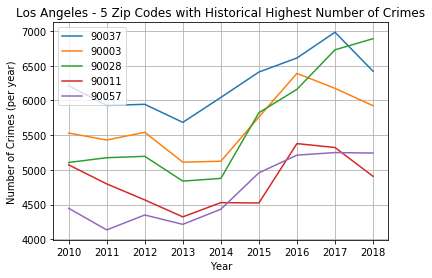

In [400]:
# plot lines
plot_90037 = plt.plot(zip_90037['year'],zip_90037['dr_no'],label=90037)
plot_90003 = plt.plot(zip_90003['year'],zip_90003['dr_no'],label=90003)
plot_90028 = plt.plot(zip_90028['year'],zip_90028['dr_no'],label=90028)
plot_90011 = plt.plot(zip_90011['year'],zip_90011['dr_no'],label=90011)
plot_90057 = plt.plot(zip_90057['year'],zip_90057['dr_no'],label=90057)
# plot layout
plt.xlabel('Year')
plt.ylabel('Number of Crimes (per year)')
plt.title('Los Angeles - 5 Zip Codes with Historical Highest Number of Crimes')
plt.legend()
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig("Images/Los Angeles - 5 Zip Codes with Historical Highest Number of Violent Crimes.png")
# show plot
plt.show()

In [401]:
# chart review:
# - disproportionate increase for zip code 90028
# - 2018 from the top 5 crime perspective shows a general decrease of crime

In [402]:
# violent crime historical review ###############################################

In [403]:
# per initial list review with team member with history in law enforcement
violent_crime_list = [ 110, 113,121,122,210,220,230,231,235,236,250,251,434,435,436,451,753,821,860,910,920]
# type(violent_crime)

In [404]:
violent_crime_df = results_df[results_df["crm_cd"].isin(violent_crime_list)]
# remove 2019
violent_crime_df = violent_crime_df.loc[violent_crime_df['year'] != 2019]
violent_crime_df

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0
5,5,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700720,4400 W WASHINGTON BL,...,H,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0
6,6,7.0,Wilshire,230,NaN,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-04-12T00:00:00.000,2010-04-12T00:00:00.000,100700734,CLOVERDALE AV,...,O,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0623,-118.3462,90036,2010,945000.0,71589.0
14,14,7.0,Wilshire,230,NaN,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-06-27T00:00:00.000,2010-06-27T00:00:00.000,100700892,1600 S HIGHLAND AV,...,B,F,KNIFE WITH BLADE 6INCHES OR LESS,200.0,34.0461,-118.3441,90019,2010,617300.0,42043.0
15,15,7.0,Wilshire,230,NaN,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-07-01T00:00:00.000,2010-07-01T00:00:00.000,100700898,4800 W WASHINGTON BL,...,W,M,STICK,308.0,34.0399,-118.3435,90019,2010,617300.0,42043.0
16,16,7.0,Wilshire,230,NaN,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-07-02T00:00:00.000,2010-07-02T00:00:00.000,100700902,WASHINGTON,...,O,M,HAND GUN,102.0,34.0399,-118.3398,90019,2010,617300.0,42043.0
19,19,7.0,Wilshire,230,NaN,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-07-15T00:00:00.000,2010-07-15T00:00:00.000,100700936,1500 MEADOWBROOK AV,...,W,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0465,-118.3510,90019,2010,617300.0,42043.0
21,21,7.0,Wilshire,230,NaN,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-05-13T00:00:00.000,2010-08-05T00:00:00.000,100700987,4000 W JOHNNIE COCH AV,...,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0418,-118.3269,90018,2010,345800.0,32447.0
22,22,7.0,Wilshire,230,NaN,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",2010-08-19T00:00:00.000,2010-08-19T00:00:00.000,100701019,700 N LA CIENEGA BL,...,W,M,BOTTLE,212.0,34.0842,-118.3765,90069,2010,696700.0,75451.0
23,23,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-08-20T00:00:00.000,2010-08-20T00:00:00.000,100701021,400 N ROSSMORE AV,...,W,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0776,-118.3273,90038,2010,525800.0,35144.0


In [405]:
# group by violent crime 
violent_crime_desc_list_intermediate = violent_crime_df.sort_values(by=["crm_cd_desc"])
aggregation = { 
     'dr_no': 'count' 
}
violent_crime_desc_list = violent_crime_desc_list_intermediate.groupby(["crm_cd_desc"]).agg(aggregation)
violent_crime_desc_list = violent_crime_desc_list.sort_values(by=["dr_no"], ascending=False)
violent_crime_desc_list.reset_index(level=0, inplace=True)
violent_crime_desc_list = violent_crime_desc_list.head()
violent_crime_desc_list = violent_crime_desc_list.replace(',', '', regex=True)
violent_crime_desc_list = violent_crime_desc_list.replace('-', '', regex=True)
violent_crime_desc_list = violent_crime_desc_list.replace(' ', '_', regex=True)
violent_crime_desc_list = violent_crime_desc_list.replace('__', '_', regex=True)
violent_crime_desc_list


,crm_cd_desc,dr_no
0,ASSAULT_WITH_DEADLY_WEAPON_AGGRAVATED_ASSAULT,81836
1,ROBBERY,75377
2,INTIMATE_PARTNER_AGGRAVATED_ASSAULT,12440
3,ATTEMPTED_ROBBERY,10780
4,BATTERY_WITH_SEXUAL_CONTACT,9966


In [406]:
# group by year / zipcode ; count number of crimes (dr_no)
zip_crime_v_intermediate = violent_crime_df.sort_values(by=['zipcode'])
aggregation = { 
     'dr_no': 'count' 
}
zip_crime_v = zip_crime_v_intermediate.groupby(['zipcode']).agg(aggregation)
zip_crime_v = zip_crime_v.sort_values(by=['dr_no'], ascending=False)
zip_crime_v.reset_index(level=0, inplace=True)
zip_crime_v.head()

,zipcode,dr_no
0,90037,11300
1,90003,9915
2,90011,8158
3,90057,7610
4,90062,7387


In [407]:
len(zip_crime_v)

169

In [408]:
zip_crime_top_v = zip_crime_v[:5]
zip_crime_top_v

,zipcode,dr_no
0,90037,11300
1,90003,9915
2,90011,8158
3,90057,7610
4,90062,7387


In [409]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
#Join together a single string of crime description
crime_type_desc = " ".join(crimedesc for crimedesc in results_df["crm_cd_desc"])
# #Create and generate a word cloud image
crime_desc_wordcloud_transparent = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate(crime_type_desc)
crime_desc_wordcloud_black = WordCloud().generate(crime_type_desc)

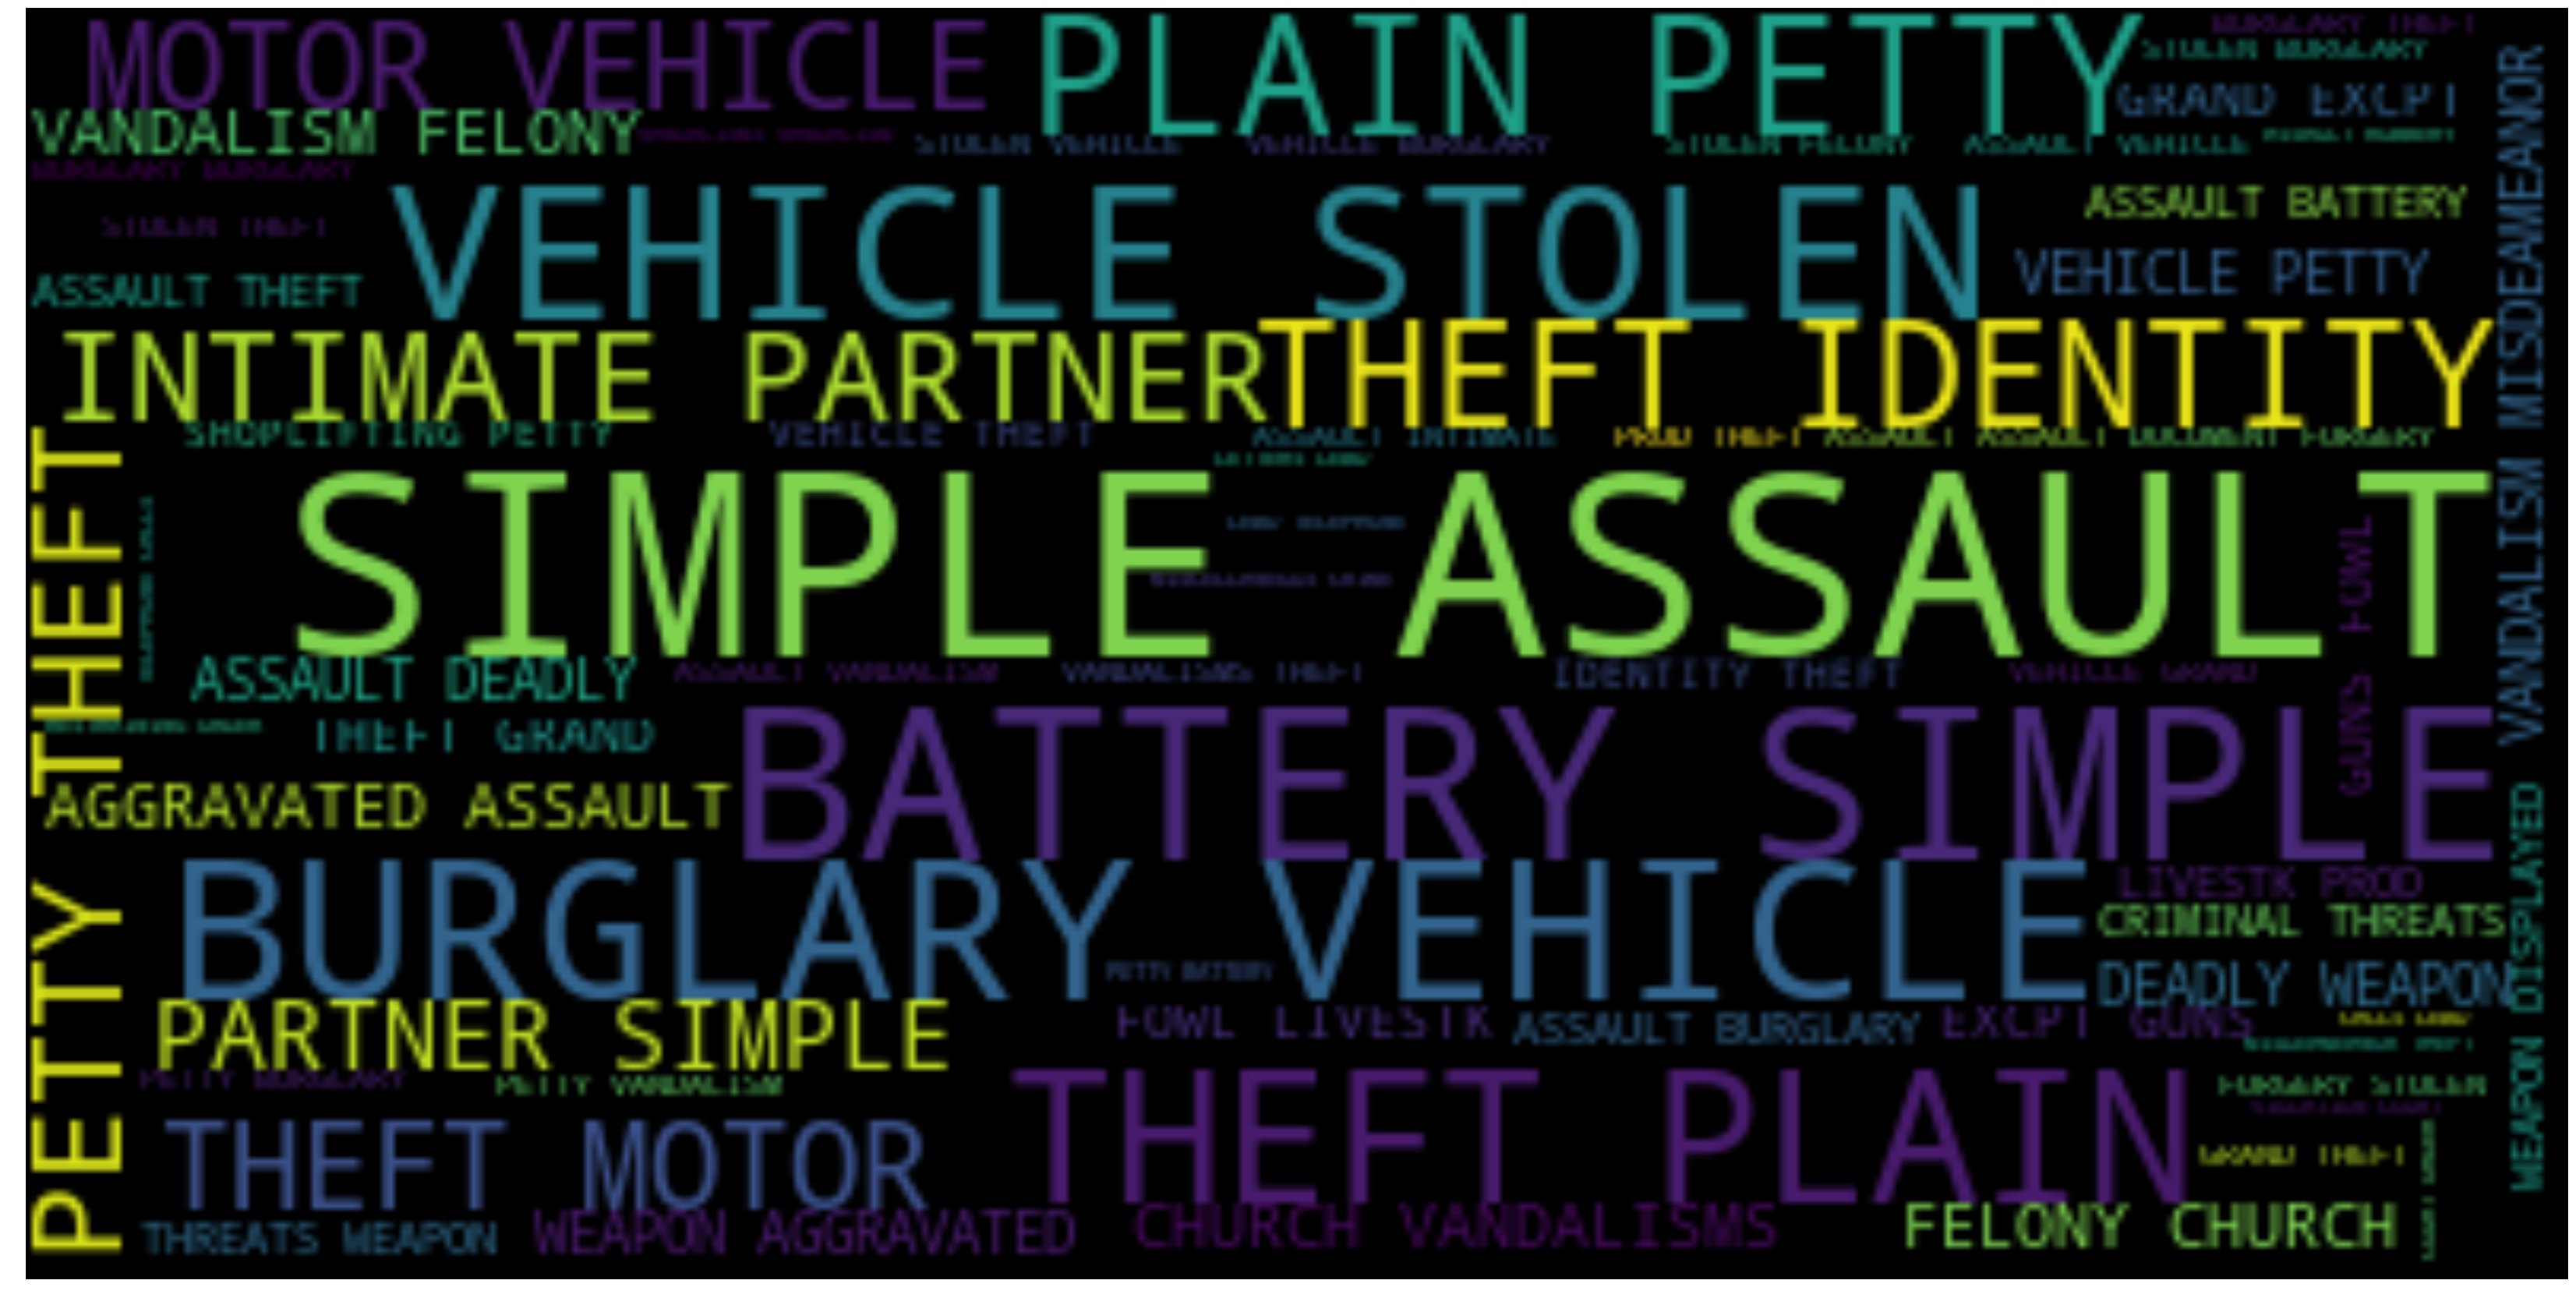

In [410]:
#Plot wordcloud image
plt.figure(figsize=[60,30])
plt.imshow(crime_desc_wordcloud_black,interpolation="bilinear")
plt.axis("off")

#Save image file
plt.savefig("Images/Crimedesc.png",format="png")

plt.show()

In [411]:
violent_crime_desc_list

,crm_cd_desc,dr_no
0,ASSAULT_WITH_DEADLY_WEAPON_AGGRAVATED_ASSAULT,81836
1,ROBBERY,75377
2,INTIMATE_PARTNER_AGGRAVATED_ASSAULT,12440
3,ATTEMPTED_ROBBERY,10780
4,BATTERY_WITH_SEXUAL_CONTACT,9966


In [412]:
violent_crime_desc_list

,crm_cd_desc,dr_no
0,ASSAULT_WITH_DEADLY_WEAPON_AGGRAVATED_ASSAULT,81836
1,ROBBERY,75377
2,INTIMATE_PARTNER_AGGRAVATED_ASSAULT,12440
3,ATTEMPTED_ROBBERY,10780
4,BATTERY_WITH_SEXUAL_CONTACT,9966


In [413]:
#Join together a single string of crime description
voilent_crime_desc_zip =[]
zip_crime_top_v_str = zip_crime_top_v
voilent_crime_desc_zip = " ".join(crimedesc for crimedesc in violent_crime_desc_list["crm_cd_desc"])
#zip_crime_top_v_str['zipcode']=  "CA_" + zip_crime_top_v_str['zipcode'].map(str)
#rows=len(zip_crime_top_v_str)
# for i in range(rows):
#     voilent_crime_desc_zip = voilent_crime_desc_zip + " " + "CA_" + rows["zipcode"].map(str)
#voilent_crime_desc_zip = " ".join(zip for zips in zip_crime_top_v_str["zipcode"])
# #Create and generate a word cloud image
voilent_crime_desc_zip_black = WordCloud().generate(voilent_crime_desc_zip)
#voilent_crime_desc_zip
#zip_crime_top_v_str

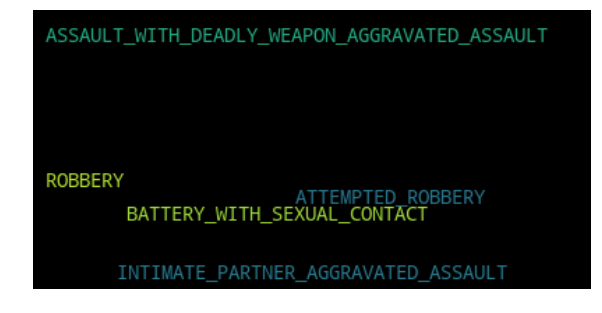

In [414]:
#Plot wordcloud image
plt.figure(figsize=[10,10])
plt.imshow(voilent_crime_desc_zip_black,interpolation="bilinear")
plt.axis("off")

#Save image file
plt.savefig("Images/Crimedesc-top5.png",format="png")

plt.show()

In [415]:
zip_crime_v.tail()

,zipcode,dr_no
164,90262,1
165,90740,1
166,90221,1
167,90805,1
168,93551,1


In [416]:
# get top into array to process zipcodes for line plot
zip_top_v = zip_crime_top_v.zipcode.unique()
zip_top_v

array([90037, 90003, 90011, 90057, 90062], dtype=int64)

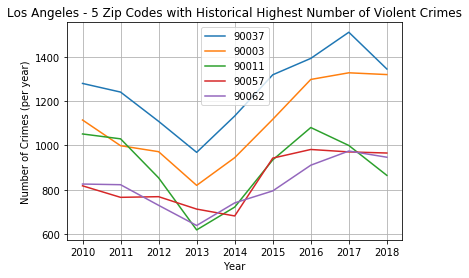

In [417]:
aggregation = { 
     'dr_no': 'nunique' 
}

zip_90037_v = violent_crime_df[violent_crime_df.zipcode == 90037].groupby(['year','zipcode']).agg(aggregation)
zip_90003_v = violent_crime_df[violent_crime_df.zipcode == 90003].groupby(['year','zipcode']).agg(aggregation)
zip_90011_v = violent_crime_df[violent_crime_df.zipcode == 90011].groupby(['year','zipcode']).agg(aggregation)
zip_90057_v = violent_crime_df[violent_crime_df.zipcode == 90057].groupby(['year','zipcode']).agg(aggregation)
zip_90062_v = violent_crime_df[violent_crime_df.zipcode == 90062].groupby(['year','zipcode']).agg(aggregation)

zip_90037_v.reset_index(level=0, inplace=True)
zip_90003_v.reset_index(level=0, inplace=True)
zip_90011_v.reset_index(level=0, inplace=True)
zip_90057_v.reset_index(level=0, inplace=True)
zip_90062_v.reset_index(level=0, inplace=True)

# plot lines
plot_90037_v = plt.plot(zip_90037_v['year'],zip_90037_v['dr_no'],label=90037)
plot_90003_v = plt.plot(zip_90003_v['year'],zip_90003_v['dr_no'],label=90003)
plot_90011_v = plt.plot(zip_90011_v['year'],zip_90011_v['dr_no'],label=90011)
plot_90057_v = plt.plot(zip_90057_v['year'],zip_90057_v['dr_no'],label=90057)
plot_90062_v = plt.plot(zip_90062_v['year'],zip_90062_v['dr_no'],label=90062)
# plot layout
plt.xlabel('Year')
plt.ylabel('Number of Crimes (per year)')
plt.title('Los Angeles - 5 Zip Codes with Historical Highest Number of Violent Crimes')
plt.legend()
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig("Images/Los Angeles - 5 Zip Codes with Historical Highest Number of Crimes.png")
# show plot
plt.show()

In [418]:
# chart review:
# - 2018 from the top 5 crime perspective shows a general decrease of crime
# = top 5 zip code 90028 from an overall crime perspective is not in top 5 from a violent crime perspective

In [419]:
# violent crime historical review overall ###############################################

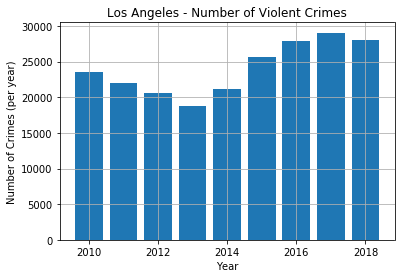

In [420]:
aggregation = { 
     'dr_no': 'nunique' 
}

overall_v = violent_crime_df.groupby(['year']).agg(aggregation)

overall_v.reset_index(level=0, inplace=True)

# plot lines
plot_overall_v = plt.bar(overall_v['year'],overall_v['dr_no'])
# plot layout
plt.xlabel('Year')
plt.ylabel('Number of Crimes (per year)')
plt.title('Los Angeles - Number of Violent Crimes')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig("Images/Los Angeles - Overall Number of Violent Crimes.png")
# show plot
plt.show()

In [421]:
overall_v

,year,dr_no
0,2010,23571
1,2011,21999
2,2012,20585
3,2013,18722
4,2014,21191
5,2015,25586
6,2016,27943
7,2017,29045
8,2018,27991


In [422]:
vc_2018vs2017 = (( overall_v['dr_no'][8] / overall_v['dr_no'][7]  ) - 1 ) * 100
vc_2018vs2017

-3.6288517817180233

In [423]:
# chart review:
# - 2018 versus 2017 from an overall violent crime perspective: from 29,045 to 27,991: decrease of 3.63 %
#   In line with article 27,246 for 2018 and a decrease of near to 4 %
#   article: https://www.latimes.com/local/lanow/la-me-lapd-crime-stats-20181229-story.html
# - Note: additional analysis done on reporting in 2015 showing inaccurate / underreporting of violent crimes
#   article: https://www.latimes.com/local/cityhall/la-me-crime-stats-20151015-story.html
#            https://github.com/datadesk/lapd-crime-classification-analysis
# - Note: changing perceptions on use and distribution of drugs and legalization can impact numbers

In [424]:
# violent crime by zip code historical review overall ###############################################

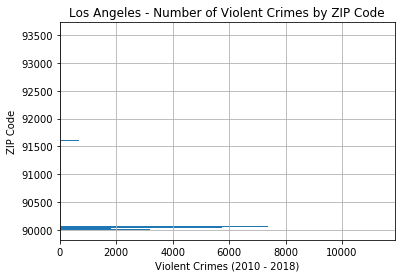

In [425]:
aggregation = { 
     'dr_no': 'nunique' 
}

zipcode_hist_v = violent_crime_df.groupby(['zipcode']).agg(aggregation)
zipcode_hist_v = zipcode_hist_v.sort_values(by=['dr_no'], ascending=True)
zipcode_hist_v.reset_index(level=0, inplace=True)

# plot lines
plot_zipcode_hist_v = plt.barh( zipcode_hist_v['zipcode'], zipcode_hist_v['dr_no'] )
# plot layout
plt.xlabel('Violent Crimes (2010 - 2018)')
plt.ylabel('ZIP Code')
plt.title('Los Angeles - Number of Violent Crimes by ZIP Code')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig("Images/Los Angeles - Number of Violent Crimes by ZIP Code.png")
# show plot
plt.show()
# to do: changes seemed to have had an impact

In [426]:
total_v =  zipcode_hist_v.sum(axis = 0, skipna = True).dr_no

In [427]:
zipcode_hist_v['perc'] = zipcode_hist_v['dr_no'] / total_v * 100
zipcode_hist_v = zipcode_hist_v.sort_values(by=['dr_no'], ascending=False)
zipcode_hist_v.reset_index(level=0, inplace=True)

# zipcode_hist_v

In [428]:
len(zipcode_hist_v)
total_10perc = 0
total_20perc = 0
i_10 = int(len(zipcode_hist_v) * 10 / 100) #10 %
i_20 = int(len(zipcode_hist_v) * 20 / 100) #20 %
counter=0
for index, row in zipcode_hist_v.iterrows():
    if counter < i_10:
        total_10perc = total_10perc + row.perc            
    if counter < i_20:
        total_20perc = total_20perc + row.perc
    counter = counter + 1

In [429]:
print(total_10perc)
print(total_20perc)

43.65678359252746
65.1872060120111


In [430]:
# the top 10 % of the zip codes account for 43.66 % of violent crime
# the top 20 % of the zip codes account for 65.19 % of violent crime

In [431]:
# violent crime by victim gender historical review overall ###############################################

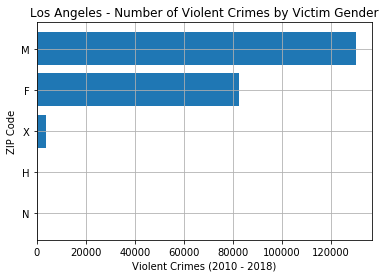

In [432]:
aggregation = { 
     'dr_no': 'nunique' 
}

vict_sex_hist_v = violent_crime_df.groupby(['vict_sex']).agg(aggregation)
vict_sex_hist_v = vict_sex_hist_v.sort_values(by=['dr_no'], ascending=True)
vict_sex_hist_v.reset_index(level=0, inplace=True)

# plot lines
plot_vict_sex_hist_v = plt.barh( vict_sex_hist_v['vict_sex'], vict_sex_hist_v['dr_no'] )
# plot layout
plt.xlabel('Violent Crimes (2010 - 2018)')
plt.ylabel('ZIP Code')
plt.title('Los Angeles - Number of Violent Crimes by Victim Gender')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig("Images/Los Angeles - Number of Violent Crimes by Victim Gender.png")
# show plot
plt.show()

In [433]:
total_vict_sex_v =  vict_sex_hist_v.sum(axis = 0, skipna = True).dr_no
vict_sex_hist_v['perc'] = vict_sex_hist_v['dr_no'] / total_vict_sex_v * 100

vict_sex_hist_v

,vict_sex,dr_no,perc
0,N,1,0.000462
1,H,14,0.006466
2,X,3636,1.679198
3,F,82641,38.165721
4,M,130240,60.148154


In [434]:
# expectation was to see a higher percentage of female victim violent crime, but graph and table show a 60.15% male victim of violent crime rate.

In [435]:
# violent crime by victim descent historical review overall ###############################################

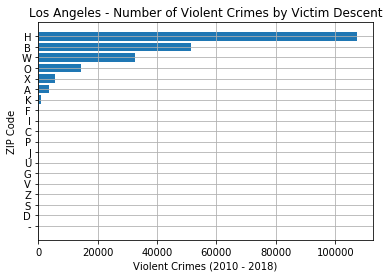

In [436]:
aggregation = { 
     'dr_no': 'nunique' 
}

vict_descent_hist_v = violent_crime_df.groupby(['vict_descent']).agg(aggregation)
vict_descent_hist_v = vict_descent_hist_v.sort_values(by=['dr_no'], ascending=True)
vict_descent_hist_v.reset_index(level=0, inplace=True)

# plot lines
plot_vict_descent_hist_v = plt.barh( vict_descent_hist_v['vict_descent'], vict_descent_hist_v['dr_no'] )
# plot layout
plt.xlabel('Violent Crimes (2010 - 2018)')
plt.ylabel('ZIP Code')
plt.title('Los Angeles - Number of Violent Crimes by Victim Descent')
plt.grid(b=None, which='major', axis='both')
# save plot
plt.savefig("Images/Los Angeles - Number of Violent Crimes by Victim Descent.png")
# show plot
plt.show()

In [437]:
total_vict_descent_v =  vict_descent_hist_v.sum(axis = 0, skipna = True).dr_no
vict_descent_hist_v['perc'] = vict_descent_hist_v['dr_no'] / total_vict_descent_v * 100

vict_descent_hist_v

,vict_descent,dr_no,perc
0,-,1,0.000462
1,D,1,0.000462
2,S,4,0.001847
3,Z,8,0.003695
4,V,10,0.004618
5,G,12,0.005542
6,U,14,0.006466
7,J,15,0.006928
8,P,19,0.008775
9,C,49,0.022630


In [438]:
# expected hispanic / black victims to be close: 49.56 % of violent crime victims are of hispanic descent

In [439]:
zip_income_housing_intermediate = processing_df.sort_values(by=['zipcode'])
aggregation = { 
     'dr_no': 'count', 'Median Household Income': 'min','Median Home Value': 'min'
}
zip_income_housing = zip_income_housing_intermediate.groupby(['zipcode']).agg(aggregation)
zip_income_housing = zip_income_housing.sort_values(by=['dr_no'], ascending=False)
zip_income_housing.reset_index(level=0, inplace=True)
zip_income_housing.head()

,zipcode,dr_no,Median Household Income,Median Home Value
0,90037,56234,26796.0,271400.0
1,90003,50984,29686.0,231700.0
2,90028,50792,30953.0,593900.0
3,90011,43418,30171.0,269300.0
4,90057,42240,28035.0,282600.0


In [440]:
# income
# fig, axs = plt.subplots(ncols=3)
# fig.set_size_inches(20, 6)
# sns.distplot(zip_income_housing["dr_no"], bins=zip_income_housing["zipcode"], ax=axs[0])
# sns.distplot(zip_income_housing["Median Household Income"], bins=zip_income_housing["zipcode"], ax=axs[1])
# sns.distplot(zip_income_housing["Median Home Value"], bins=zip_income_housing["zipcode"], ax=axs[2])


# plt.close(2)
# plt.close(3)
# plt.close(4)
# plt.show()

# g = sns.catplot(x="zipcode", y="dr_no", 
#                  data=zip_income_housing, saturation=.5,
#                  kind="bar", ci=None, aspect=.6)
# (g.set_axis_labels("Zip Code", "Crime Count")
#    .set_xticklabels(zip_income_housing["zipcode"])
# #   .set_titles("{col_name} {col_var}")
# #   .set(ylim=(0, 1))
#    .despine(left=True))  
# plt.show()

In [441]:
processing_df.head() 

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010,945000.0,71589.0
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010,945000.0,71589.0
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010,941100.0,72701.0
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010,633600.0,31893.0
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0


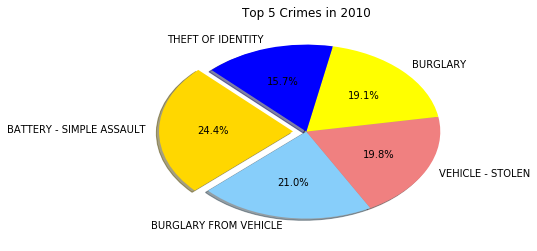

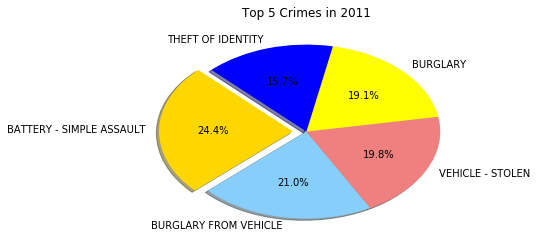

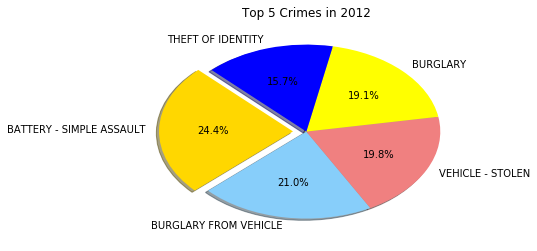

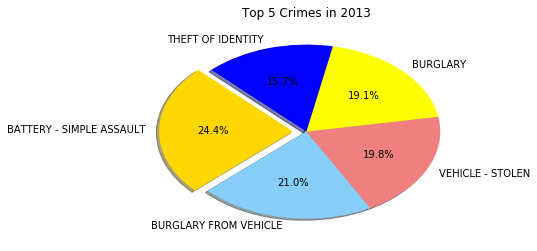

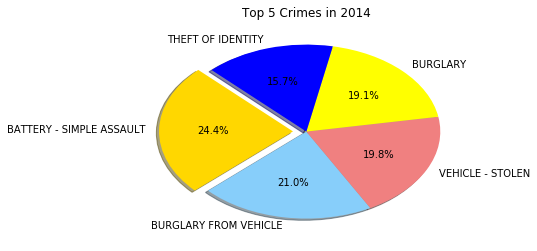

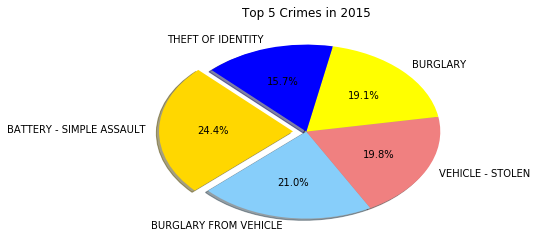

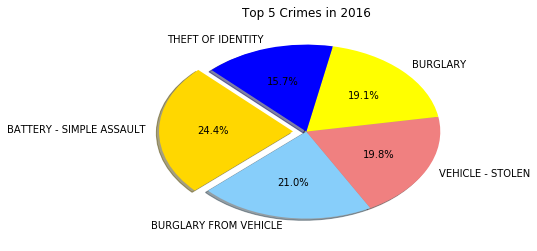

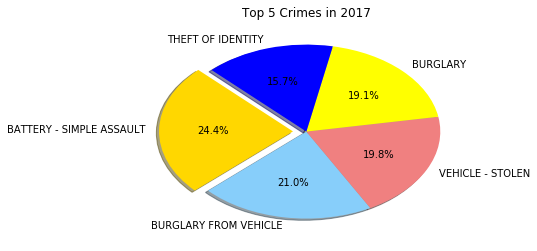

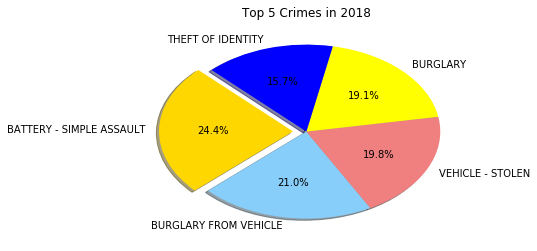

In [442]:
# Calculate Top five crimes per year
crimes_per_year_desc_intermediate = processing_df.sort_values(by=["year","crm_cd_desc"])
aggregation = { 
     "dr_no": 'count' 
}
explode = (0.1,0, 0,0,0)
colors=["Gold","LightSkyBlue","LightCoral","Yellow","Blue"]
crimes_per_year_desc = crimes_per_year_desc_intermediate.groupby(["year","crm_cd_desc"]).agg(aggregation)
crimes_per_year_desc.reset_index(level=0, inplace=True)
for i in range(2010,2019):
    data_year = i
    crimes_per_year_desc = crimes_per_year_desc[crimes_per_year_desc.year == 2010].sort_values(by=["dr_no"], ascending=False)
    top_crimes_per_year_desc =crimes_per_year_desc.head(5)
    plt.pie(top_crimes_per_year_desc.dr_no, labels = top_crimes_per_year_desc.index, autopct = "%1.1f%%", colors = colors, explode = explode, shadow = True, startangle = 135)       
    plt.title(f"Top 5 Crimes in {data_year}")
    #Save Figure
    plt.savefig(f"Images/Top 5 Crimes in {data_year}.png", bbox_inches="tight")
    plt.show()

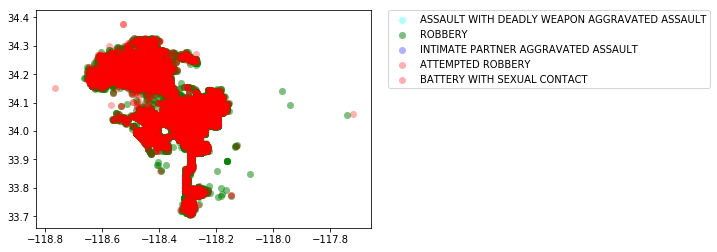

In [443]:
# Top Crime on Longitude and Latitude
plt.scatter(results_df['lon'][results_df['crm_cd_desc']=='ASSAULT WITH DEADLY WEAPON AGGRAVATED ASSAULT'], results_df['lat'][results_df['crm_cd_desc']=='ASSAULT WITH DEADLY WEAPON AGGRAVATED ASSAULT'], s=50, alpha=0.3, color=[0.0,1.0,1.0], lw=0, label='ASSAULT WITH DEADLY WEAPON AGGRAVATED ASSAULT')
plt.scatter(results_df['lon'][results_df['crm_cd_desc']=='ROBBERY'], results_df['lat'][results_df['crm_cd_desc']=='ROBBERY'], s=50, alpha=0.5, color='g', lw=0, label='ROBBERY')
plt.scatter(results_df['lon'][results_df['crm_cd_desc']=='INTIMATE PARTNER AGGRAVATED ASSAULT'], results_df['lat'][results_df['crm_cd_desc']=='INTIMATE PARTNER AGGRAVATED ASSAULT'], s=50, alpha=0.3, color='b', lw=0, label='INTIMATE PARTNER AGGRAVATED ASSAULT')
plt.scatter(results_df['lon'][results_df['crm_cd_desc']=='ATTEMPTED ROBBERY'], results_df['lat'][results_df['crm_cd_desc']=='ATTEMPTED ROBBERY'], s=50, alpha=0.3, color='r', lw=0, label='ATTEMPTED ROBBERY')
plt.scatter(results_df['lon'][results_df['crm_cd_desc']=='BATTERY WITH SEXUAL CONTACT'], results_df['lat'][results_df['crm_cd_desc']=='BATTERY WITH SEXUAL CONTACT'], s=50, alpha=0.3, color='r', lw=0, label='BATTERY WITH SEXUAL CONTACT')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# # Save Figure
plt.savefig(f"Images/Top Crime on Longitude Latitude axes.png", bbox_inches="tight")
plt.show()

In [444]:
#processing_df.reset_index(drop=True)
processing_df.head(5)

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010,945000.0,71589.0
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010,945000.0,71589.0
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010,941100.0,72701.0
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010,633600.0,31893.0
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0


In [445]:
# if "new_date_column" in processing_df.columns:
#     processing_df.drop(columns=["new_date_column"])
# processing_df.reset_index(drop=True)
# # # if "day_of_week" in processing_df.columns:
# # #     processing_df.drop(columns=["day_of_week"])
# # # df.loc[:, ['B', 'A']] = df[['A', 'B']]
# # pd.options.mode.chained_assignment = None
# processing_df.loc[:"new_date_column"]= pd.to_datetime(processing_df["date_occ"], format="%Y%m%d", errors="ignore")
# processing_df.index = pd.DatetimeIndex(processing_df.new_date_column)
processing_df.head(5)

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010,945000.0,71589.0
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010,945000.0,71589.0
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010,941100.0,72701.0
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010,633600.0,31893.0
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0


In [446]:
# processing_df["day_of_week"] = processing_df["new_date_column"].dt.day_name()
# processing_df.index = pd.DatetimeIndex(processing_df["new_date_column"])
# processing_df["new_date_column","day_of_week"].head(10)

In [447]:
# #make graph of crimes per month
# processing_df.groupby([processing_df.index.month]).size().plot.bar()
# plt.title("Crime Per Month")
# plt.xlabel("Month")
# plt.ylabel("Number of Crimes Acts")
# plt.savefig(f"Images/Crime Per Month.png", bbox_inches="tight")
# plt.show()
# #graph of crimes per day
# processing_df.groupby([processing_df.index.weekday]).size().plot.bar()
# #processing_df.sort_values([processing_df.index.weekday]).groupby([processing_df.day_of_week]).size().plot.bar()
# plt.title("Crime Per WeekDay Of Month")
# plt.xlabel("WeekDay")
# #plt.legend(f"{processing_df.index.weekday}-{processing_df.index.weekday}")
# plt.ylabel("Number of Crimes Acts")
# plt.savefig(f"Images/Crime Per WeekDay Of Month.png", bbox_inches="tight")
# plt.show()

In [448]:
# Use google maps api
with open('apikey.txt') as f:
    api_key = f.readline()
    f.close
gmaps.configure(api_key=api_key) 
los_angeles_coordinates = (34.0522, -118.2437) # Fill in with your API key
# #Get the locations from the data set
locations = processing_df[processing_df.year == 2018][["lat", "lon"]]
# #Get the magnitude from the data
weights = processing_df[processing_df.year == 2018]["dr_no"]
# #Set up your map
fig = gmaps.figure(center=los_angeles_coordinates, zoom_level=10)
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig
#plt.savefig(f"Images/Peace Discruption-HeatMap-2018.png")

Figure(layout=FigureLayout(height='420px'))

Crime Rates vs. Median Income/Home Values

In [450]:
results_df.head()

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010,945000.0,71589.0
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010,945000.0,71589.0
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010,941100.0,72701.0
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010,633600.0,31893.0
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300.0,42043.0


C:\Users\khano\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\khano\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

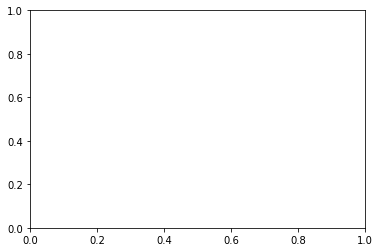

In [449]:
# plot number of crime reports over housing values
mhv = results_df["Median Home Value"]
plt.hist(mhv, bins = 11)
plt.xlabel("Median Home Value")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports by Median Home Value')
plt.show()

C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


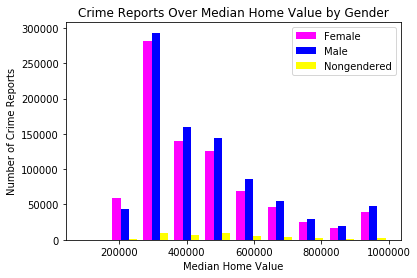

In [451]:
# Create subsets of dataframe by gender (female, male, unspecified/nongendered)
f_df = results_df.loc[results_df["vict_sex"] == "F"]
m_df = results_df.loc[results_df["vict_sex"] == "M"]
nongendered = ["X", "H", "N", "-"]
x_df = results_df.loc[results_df["vict_sex"].isin(nongendered)]

# Plot crime reports over home values by gender
f_mhv = f_df["Median Home Value"]
m_mhv = m_df["Median Home Value"]
x_mhv = x_df["Median Home Value"]

legend = ["Female", "Male", "Nongendered"]
plt.hist([f_mhv, m_mhv, x_mhv], color=["magenta", "blue", "yellow"])
plt.xlabel("Median Home Value")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Home Value by Gender')
plt.legend(legend)
plt.show()

C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


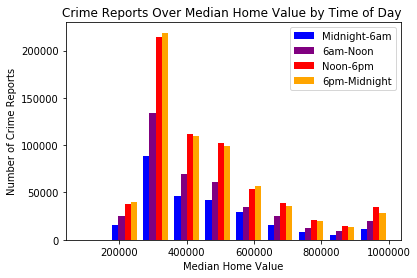

In [452]:
# Create subsets of dataframe by time of day (early morning, morning, afternoon, night)
early_df = results_df.loc[results_df["time_occ"] <= 599]

morn_df_temp = results_df.loc[results_df["time_occ"] <= 1199]
morn_df = morn_df_temp.loc[morn_df_temp["time_occ"] >= 600]

after_df_temp = results_df.loc[results_df["time_occ"] <= 1799]
after_df = after_df_temp.loc[after_df_temp["time_occ"] >= 1200]

late_df = results_df.loc[results_df["time_occ"] >= 1800]

# Plot crime reports over home values by gender
early_mhv = early_df["Median Home Value"]
morn_mhv = morn_df["Median Home Value"]
after_mhv = after_df["Median Home Value"]
late_mhv = late_df["Median Home Value"]

legend = ["Midnight-6am", "6am-Noon", "Noon-6pm", "6pm-Midnight"]
plt.hist([early_mhv, morn_mhv, after_mhv, late_mhv], color=["blue", "purple", "red", "orange"])
plt.xlabel("Median Home Value")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Home Value by Time of Day ')
plt.legend(legend)
plt.show()

C:\Users\khano\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\khano\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


ValueError: max must be larger than min in range parameter.

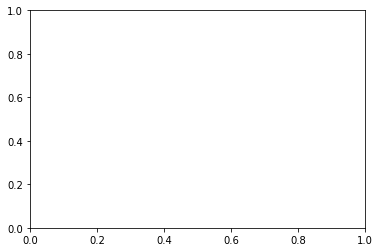

In [453]:
# plot number of crime reports over housing values
mhi = results_df["Median Household Income"]
plt.hist(mhi, bins = 10, color = "green")
plt.xlabel("Median Household Income")
plt.ylabel("Number of Crime Reports")
plt.title("Crime Reports by Median Household Income")
plt.show()

C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


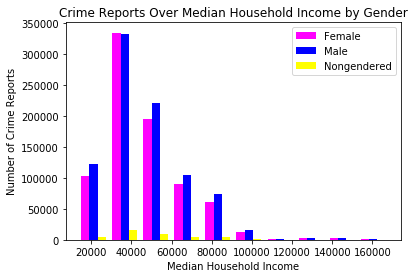

In [454]:
# Plot crime reports over income by gender
f_mhi = f_df["Median Household Income"]
m_mhi = m_df["Median Household Income"]
x_mhi = x_df["Median Household Income"]

legend = ["Female", "Male", "Nongendered"]
plt.hist([f_mhi, m_mhi, x_mhi], color=["magenta", "blue", "yellow"])
plt.xlabel("Median Household Income")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Household Income by Gender')
plt.legend(legend)
plt.show()

C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\khano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


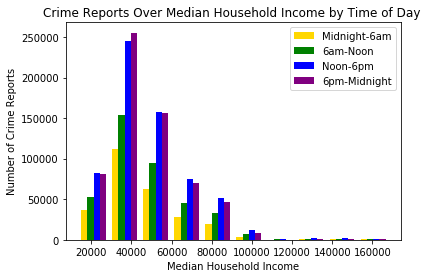

In [455]:
# Create subsets of income dataframe by time of day (early morning, morning, afternoon, night)
early_mhi = early_df["Median Household Income"]
morn_mhi = morn_df["Median Household Income"]
after_mhi = after_df["Median Household Income"]
late_mhi = late_df["Median Household Income"]

# Plot 
legend = ["Midnight-6am", "6am-Noon", "Noon-6pm", "6pm-Midnight"]
plt.hist([early_mhi, morn_mhi, after_mhi, late_mhi], color=["gold", "green", "blue", "purple"])
plt.xlabel("Median Household Income")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Household Income by Time of Day ')
plt.legend(legend)
plt.show()